In [1]:
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / "_scripts"))

In [4]:
import networkx as nx
from eppy.bunch_subclass import EpBunch
from geomeppy import IDF

from case_edits.ezcase import *
from helpers.ep_helpers import *
from helpers.ep_geom_helpers import *
from helpers.geometry_interfaces import *
from helpers.helpers import *
from plan.helpers import get_plans_from_file
from network.network import *
from network.visuals import *
from subsurfaces.logic import get_connecting_surface
from helpers.variables import *
from helpers.variable_interfaces import *
from munch import Munch
from helpers.read_sql import *

from dataclasses import dataclass
from pprint import pprint
import sqlite3
from case_edits.epcase import EneryPlusCaseEditor
from helpers.output_requests import request_sql

import seaborn as sns
from setup.setup import get_case_names, CaseData, retrieve_cases
from setup.plots import *
from setup.data_wrangle import *

import polars as pl
import datetime as dt
from datetime import datetime
from ladybug.dt import DateTime

# # Apply the default theme
# sns.set_theme()

In [26]:
qoi1 = 'AFN Linkage Node 1 to Node 2 Volume Flow Rate'
qoi2 = "Site Wind Speed"
qoi3 = "Site Wind Direction"

In [27]:
case_data = retrieve_cases()
sample_case = case_data[0]
df = create_dataframe_for_all_cases(case_data, qoi1)
df.head()

case_names,space_names,qoi,values,datetimes
str,str,str,f64,datetime[μs]
"""amb_b1""","""BLOCK 01 STOREY 0 WALL 0001_2 …","""AFN Linkage Node 1 to Node 2 V…",0.189875,2017-07-01 00:00:00
"""amb_b1""","""BLOCK 01 STOREY 0 WALL 0001_2 …","""AFN Linkage Node 1 to Node 2 V…",0.229261,2017-07-01 00:15:00
"""amb_b1""","""BLOCK 01 STOREY 0 WALL 0001_2 …","""AFN Linkage Node 1 to Node 2 V…",0.262846,2017-07-01 00:30:00
"""amb_b1""","""BLOCK 01 STOREY 0 WALL 0001_2 …","""AFN Linkage Node 1 to Node 2 V…",0.285586,2017-07-01 00:45:00
"""amb_b1""","""BLOCK 01 STOREY 0 WALL 0001_2 …","""AFN Linkage Node 1 to Node 2 V…",0.28513,2017-07-01 01:00:00


In [29]:
df2 = join_site_data(sample_case, qoi3, df)
df2.head()

case_names,space_names,qoi,values,datetimes,qoi_right,values_right
str,str,str,f64,datetime[μs],str,f64
"""amb_b1""","""BLOCK 01 STOREY 0 WALL 0001_2 …","""AFN Linkage Node 1 to Node 2 V…",0.189875,2017-07-01 00:00:00,"""Site Wind Direction""",305.0
"""amb_b1""","""BLOCK 01 STOREY 0 WALL 0001_2 …","""AFN Linkage Node 1 to Node 2 V…",0.229261,2017-07-01 00:15:00,"""Site Wind Direction""",300.0
"""amb_b1""","""BLOCK 01 STOREY 0 WALL 0001_2 …","""AFN Linkage Node 1 to Node 2 V…",0.262846,2017-07-01 00:30:00,"""Site Wind Direction""",295.0
"""amb_b1""","""BLOCK 01 STOREY 0 WALL 0001_2 …","""AFN Linkage Node 1 to Node 2 V…",0.285586,2017-07-01 00:45:00,"""Site Wind Direction""",290.0
"""amb_b1""","""BLOCK 01 STOREY 0 WALL 0001_2 …","""AFN Linkage Node 1 to Node 2 V…",0.28513,2017-07-01 01:00:00,"""Site Wind Direction""",290.0


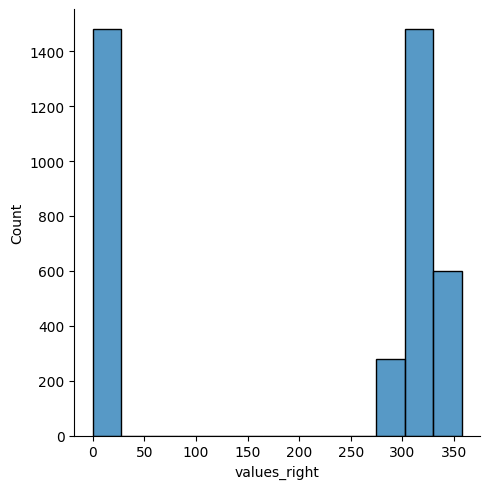

In [30]:
sns.displot(df2, x="values_right")

In [18]:
all_variables.site.wind

{'speed': 'Site Wind Speed', 'direction': 'Site Wind Direction'}

In [20]:
wind_dir = create_dataframe_for_case(sample_case.case_name, sample_case.sql, all_variables.site.wind["direction"])
wind_dir.head()

case_names,zone_names,qoi,values,datetimes
str,str,str,f64,datetime[μs]
"""amb_b1""","""Environment""","""Site Wind Direction""",305.0,2017-07-01 00:00:00
"""amb_b1""","""Environment""","""Site Wind Direction""",300.0,2017-07-01 00:15:00
"""amb_b1""","""Environment""","""Site Wind Direction""",295.0,2017-07-01 00:30:00
"""amb_b1""","""Environment""","""Site Wind Direction""",290.0,2017-07-01 00:45:00
"""amb_b1""","""Environment""","""Site Wind Direction""",290.0,2017-07-01 01:00:00


In [26]:
wind_dir["zone_names"].unique()

zone_names
str
"""Environment"""


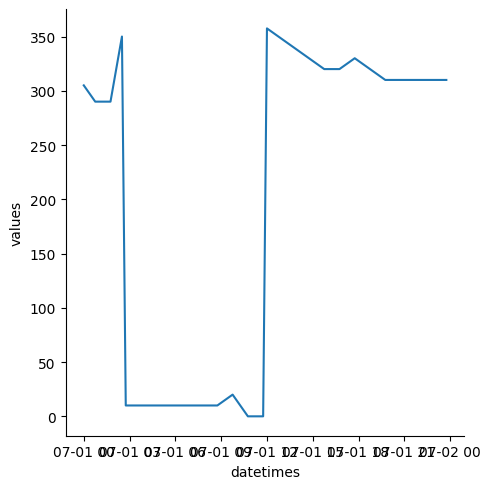

In [21]:
sns.relplot(data=wind_dir, x="datetimes", y="values", kind="line")

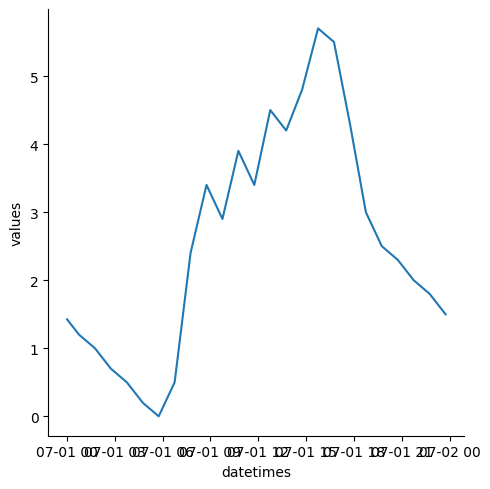

In [22]:
wind_speed = create_dataframe_for_case(sample_case.case_name, sample_case.sql, all_variables.site.wind["speed"])
sns.relplot(data=wind_speed, x="datetimes", y="values", kind="line")

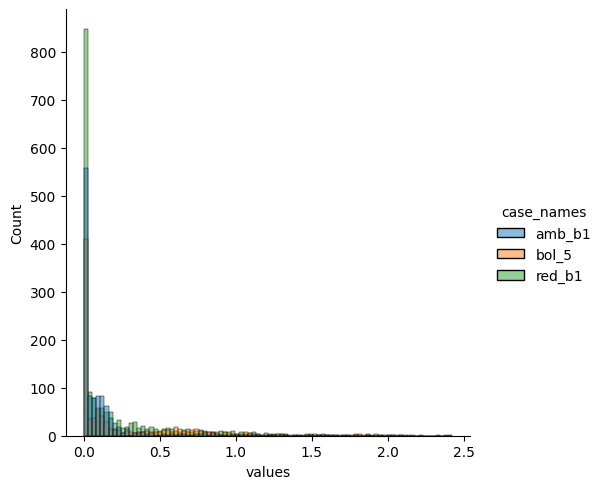

In [11]:
sns.displot(df, x="values", hue="case_names" )

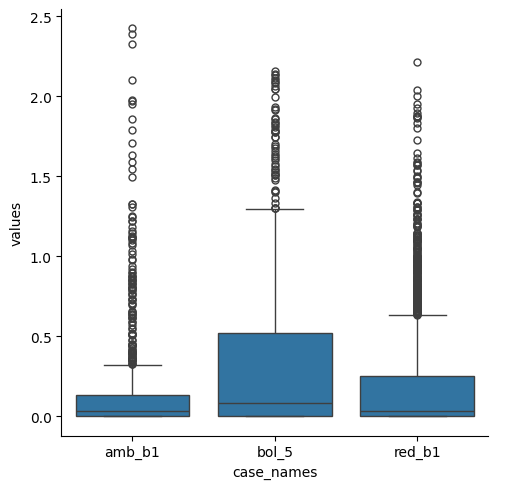

In [13]:
sns.catplot(df, y="values", x="case_names",  kind="box")